# California Housing Prices - Clustering

The aim of this workbook is to train an Unsupervised Model using the California Housing Prices Dataset.

- url : https://www.kaggle.com/datasets/camnugent/california-housing-prices

At the end of the workbook I will have trained three models using K-Means, Mean Shift and DBSCAN to analyse and draw ____ from the data.

## Lib Imports

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
from sklearn.preprocessing import StandardScaler

# Data Loading

In [35]:
housing_df = pd.read_csv('housing.csv')

In [36]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [37]:
housing_df.isna().sum() * 100 / len(housing_df)

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

So there only seem to be missing entries for total_bedrooms, and the missing values account for 1.% of values, which is insignificant. I'm going to quickly review the object column ocean_property to make sure there aren't any missing values there either.

In [38]:
housing_df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

Seems fine so I will drop all missing values from the dataframe.

In [39]:
housing_df.dropna(inplace=True)
housing_df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [40]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Now I am going to have a review of the numerical features.

In [41]:
NUMERICAL_COLS = [col for col in housing_df.columns if housing_df[col].dtype != 'object']

In [42]:
housing_df[NUMERICAL_COLS].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

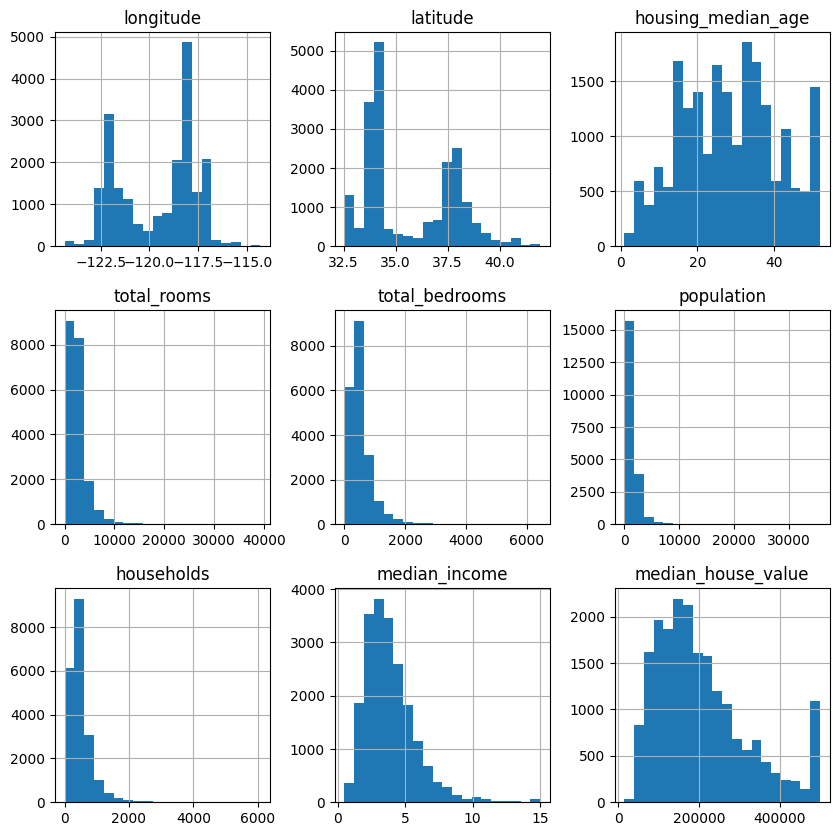

In [43]:
housing_df[NUMERICAL_COLS].hist(bins=20, figsize=(10, 10))

Alot of the numerical columns are exhibiting positive skewness, with the mode value being less than the mean. As such the dataset will have to be normalized prior to any clustering.

## 2. EDA

### 2.1 Data Preprocessing

We are going to need to normalize the numerical cols, and apply one hot encoding to the categorical cols.

In [27]:
def preprocess_df(df, numerical_cols):
    NUMERICAL_COLS = [col for col in df if df[col].dtype != 'object']
    CATEGORICAL_COLS = [col for col in df.columns if col not in NUMERICAL_COLS]
    ss = StandardScaler()
    df[NUMERICAL_COLS] = ss.fit_transform(df[NUMERICAL_COLS])
    categorial_df = pd.get_dummies(housing_df[CATEGORICAL_COLS])
    pd[categorical_df.columns] = categorical_df.values
    pd.drop(CATEGORICAL_COLS, inplace=True, axis=1)

__Latitude vs Longitude Scatter__

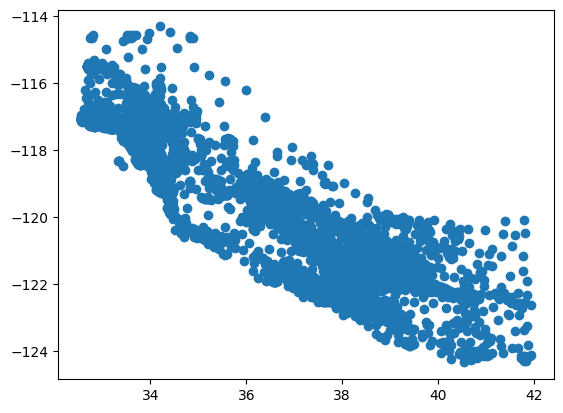

In [20]:
plt.scatter(housing_df['latitude'], housing_df['longitude'])

__Median Income vs Median House Value__

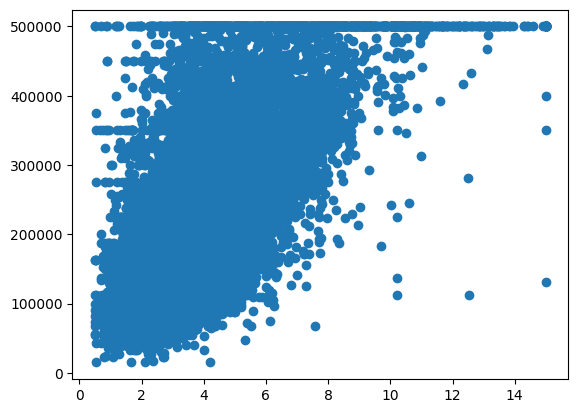

In [21]:
plt.scatter(housing_df['median_income'], housing_df['median_house_value'])

In [ ]:
plt.scatter(housing_df['median_house_value'], housing_df)